![title](imgs/tensorboard.png)

# Tensorflow Convolutional Neural Network - with Tensorboard support

Import tensorflow module, mnist dataset and matplotlib library for ploting learning history

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

Load MNIST data

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Create layer method


In this cells methods for individual layers are created. 

First method represent auxiliary method, which can be use for **Tensorboard** support. Method save summaries for *standard deviation*, *maximum* and *minimum* activation.

In [3]:
def variable_summaries(var, name):
    with tf.name_scope('summaries_{}'.format(name)):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram(name, var)

Tensorboard tutorial can be found here: https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard

Using Tensorboard could be as simple as adding few neccessary line to your code.
Few types of summaries are avalible for tensorboard:
* Scalar summary
* Histogram summary
* Music Summary
* Image Summary

After adding variable to summary, all summaries should be merged and runned in main program loop.
Very usefull is also introducing names for block of tensorflow code. That trick will extensivly improve readibility of tensorboard Graph.

Second method represents convolutional Layer, which will be used as building block of our Convolutional network

In [4]:
def convolutional_layer(layer_input, layer_size, activation="linear", stride=1, stddev=0.1, padding='same', 
                        name="convolutional_layer"):
    # Input layer shape
    input_shape = layer_input.get_shape().as_list()[1:]
    input_shape_filters = input_shape[-1]
    
    with tf.name_scope(name):
        weights = tf.Variable(tf.truncated_normal([layer_size[0], layer_size[1], input_shape_filters, 
                                                   layer_size[2]], stddev=stddev))
        bias = tf.Variable(tf.ones([layer_size[2]]) / 10)
        not_activated = tf.nn.conv2d(layer_input, weights, strides=[1, stride, stride, 1], padding=padding.upper())
        not_activated = tf.nn.bias_add(not_activated, bias)

        if activation != 'linear':
            activated_output = getattr(tf.nn, activation)(not_activated)
        else:
            activated_output = not_activated

        #  Get histograms
        variable_summaries(weights, "weights")
        variable_summaries(bias, "biases")
        tf.summary.histogram("activations", activated_output)
    return activated_output
    

Define Flatten layer, which will reshape our convolutional output to vector

In [5]:
def faltten(layer_input, name="flatten"):
    with tf.name_scope(name):
        input_shape = layer_input.get_shape().as_list()[1:]
    return tf.reshape(Y3, shape=[-1, np.prod(input_shape)])

Define Fully connected layer

In [6]:
def fully_connected_layer(layer_input, output_size, activation="linear", name="fully_connected"):
    input_shape = layer_input.get_shape().as_list()[1:]
    with tf.name_scope(name):
        weights = tf.Variable(tf.truncated_normal([int(np.prod(input_shape)), output_size], stddev=0.1))
        bias = tf.Variable(tf.ones([output_size]) / 10)
        
        not_activated = tf.matmul(layer_input, weights)
        not_activated = tf.nn.bias_add(not_activated, bias)

        if activation != 'linear':
            activated_output = getattr(tf.nn, activation)(not_activated)
        else:
            activated_output = not_activated
        variable_summaries(weights, "weights")
        variable_summaries(bias, "biases")
        tf.summary.histogram("activations", activated_output)
    return activated_output

Define variables and graph for neural network mode

In [7]:
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y1 = convolutional_layer(X, [6, 6, 6], activation="relu", stride=1, padding="same", stddev=0.1, name="convo_1")
Y2 = convolutional_layer(Y1, [6, 6, 12], activation="relu", stride=1, padding="same", stddev=0.1, name="convo_1")
Y3 = convolutional_layer(Y2, [6, 6, 24], activation="relu", stride=1, padding="same", stddev=0.1, name="convo_1")

YY = faltten(Y3, name="flatten")
Y4 = fully_connected_layer(YY, output_size=200, activation="relu", name="fc_1")
Y4_d = tf.nn.dropout(Y4, 0.75)
Ylogits = fully_connected_layer(Y4_d, 10, activation="linear", name="fc_1")
Y = tf.nn.softmax(Ylogits)

Placeholder for Y labels

In [8]:
Y_pred = tf.placeholder(tf.float32, [None, 10])

Define cross entropy [*loss function*]

In [9]:
with tf.name_scope("Cross_entropy"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_pred)
    cross_entropy = tf.reduce_mean(cross_entropy)
    tf.summary.scalar("cross_entropy", cross_entropy)

In [10]:
with tf.name_scope("Accuracy"):
    is_correct = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_pred, 1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

Define Gradient Descent Optimizer

In [11]:
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(cross_entropy)

In [12]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [13]:
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./logs")
writer.add_graph(sess.graph)

In [14]:
test_accuracy = []
test_cross = []
for i in range(2000):
    # Load batch
    batch_X, batch_Y = mnist.train.next_batch(100)
    batch_X = batch_X.reshape((100, 28, 28, 1))
    train_data = {X: batch_X, Y_pred: batch_Y}

    # Train
    sess.run(train_step, feed_dict=train_data)
    a_train, c_train = sess.run([accuracy, cross_entropy], feed_dict=train_data)

    test_batch_x = mnist.test.images
    test_batch_x = test_batch_x.reshape((10000, 28, 28, 1))
    test_data = {X: test_batch_x, Y_pred: mnist.test.labels}
    a_test, c_test = sess.run([accuracy, cross_entropy], feed_dict=test_data)
    print("Train data Accuracy: {}, Train data Cross Entropy: {}".format(a_train, c_train))
    print("Test data Accuracy: {}, Test data Cross Entropy: {}".format(a_test, c_test))

    # Save summary
    if i % 5 == 0:
        sum_res = sess.run(merged_summary, train_data)
        writer.add_summary(sum_res, i)
    
    # Append to list
    test_accuracy.append(a_test)
    test_cross.append(c_test)

Train data Accuracy: 0.20000000298023224, Train data Cross Entropy: 3.240445613861084
Test data Accuracy: 0.11919999867677689, Test data Cross Entropy: 3.3857269287109375
Train data Accuracy: 0.1599999964237213, Train data Cross Entropy: 3.0096733570098877
Test data Accuracy: 0.13099999725818634, Test data Cross Entropy: 3.2426505088806152
Train data Accuracy: 0.17000000178813934, Train data Cross Entropy: 3.0467023849487305
Test data Accuracy: 0.1396999955177307, Test data Cross Entropy: 3.139021873474121
Train data Accuracy: 0.14000000059604645, Train data Cross Entropy: 2.918104887008667
Test data Accuracy: 0.15139999985694885, Test data Cross Entropy: 3.012371063232422
Train data Accuracy: 0.20999999344348907, Train data Cross Entropy: 2.646592140197754
Test data Accuracy: 0.15929999947547913, Test data Cross Entropy: 2.932709217071533
Train data Accuracy: 0.1899999976158142, Train data Cross Entropy: 2.8166303634643555
Test data Accuracy: 0.1770000010728836, Test data Cross Entrop

Train data Accuracy: 0.7099999785423279, Train data Cross Entropy: 1.0255571603775024
Test data Accuracy: 0.7067000269889832, Test data Cross Entropy: 0.9345045685768127
Train data Accuracy: 0.7200000286102295, Train data Cross Entropy: 1.0039860010147095
Test data Accuracy: 0.7102000117301941, Test data Cross Entropy: 0.9184185266494751
Train data Accuracy: 0.6800000071525574, Train data Cross Entropy: 0.912946343421936
Test data Accuracy: 0.7135000228881836, Test data Cross Entropy: 0.9044374823570251
Train data Accuracy: 0.699999988079071, Train data Cross Entropy: 0.9434950351715088
Test data Accuracy: 0.722599983215332, Test data Cross Entropy: 0.8825927972793579
Train data Accuracy: 0.6399999856948853, Train data Cross Entropy: 1.0073649883270264
Test data Accuracy: 0.7289999723434448, Test data Cross Entropy: 0.8802396655082703
Train data Accuracy: 0.6700000166893005, Train data Cross Entropy: 1.0942739248275757
Test data Accuracy: 0.7278000116348267, Test data Cross Entropy: 0.

Train data Accuracy: 0.8500000238418579, Train data Cross Entropy: 0.6033637523651123
Test data Accuracy: 0.8294000029563904, Test data Cross Entropy: 0.5563831925392151
Train data Accuracy: 0.8399999737739563, Train data Cross Entropy: 0.5987434387207031
Test data Accuracy: 0.8287000060081482, Test data Cross Entropy: 0.5528519749641418
Train data Accuracy: 0.8299999833106995, Train data Cross Entropy: 0.5712183713912964
Test data Accuracy: 0.8327000141143799, Test data Cross Entropy: 0.5491890907287598
Train data Accuracy: 0.800000011920929, Train data Cross Entropy: 0.5667267441749573
Test data Accuracy: 0.8346999883651733, Test data Cross Entropy: 0.5378783941268921
Train data Accuracy: 0.8399999737739563, Train data Cross Entropy: 0.4900151193141937
Test data Accuracy: 0.8345999717712402, Test data Cross Entropy: 0.5428489446640015
Train data Accuracy: 0.7699999809265137, Train data Cross Entropy: 0.6282217502593994
Test data Accuracy: 0.8337000012397766, Test data Cross Entropy: 

Train data Accuracy: 0.8700000047683716, Train data Cross Entropy: 0.42477351427078247
Test data Accuracy: 0.8691999912261963, Test data Cross Entropy: 0.4313252866268158
Train data Accuracy: 0.8899999856948853, Train data Cross Entropy: 0.40100887417793274
Test data Accuracy: 0.8729000091552734, Test data Cross Entropy: 0.42749911546707153
Train data Accuracy: 0.8600000143051147, Train data Cross Entropy: 0.4436710476875305
Test data Accuracy: 0.8701000213623047, Test data Cross Entropy: 0.4310656785964966
Train data Accuracy: 0.7799999713897705, Train data Cross Entropy: 0.6795869469642639
Test data Accuracy: 0.8723000288009644, Test data Cross Entropy: 0.41885262727737427
Train data Accuracy: 0.8500000238418579, Train data Cross Entropy: 0.4694754481315613
Test data Accuracy: 0.8738999962806702, Test data Cross Entropy: 0.4124414920806885
Train data Accuracy: 0.8600000143051147, Train data Cross Entropy: 0.3970506191253662
Test data Accuracy: 0.8748999834060669, Test data Cross Entr

Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.257547527551651
Test data Accuracy: 0.8942999839782715, Test data Cross Entropy: 0.3553682267665863
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.1962757259607315
Test data Accuracy: 0.8935999870300293, Test data Cross Entropy: 0.35729315876960754
Train data Accuracy: 0.9100000262260437, Train data Cross Entropy: 0.270428866147995
Test data Accuracy: 0.8925999999046326, Test data Cross Entropy: 0.35757318139076233
Train data Accuracy: 0.8700000047683716, Train data Cross Entropy: 0.3145166337490082
Test data Accuracy: 0.8963000178337097, Test data Cross Entropy: 0.3478753864765167
Train data Accuracy: 0.8700000047683716, Train data Cross Entropy: 0.2957763075828552
Test data Accuracy: 0.8938000202178955, Test data Cross Entropy: 0.35238662362098694
Train data Accuracy: 0.8899999856948853, Train data Cross Entropy: 0.3821435272693634
Test data Accuracy: 0.8949000239372253, Test data Cross Entropy: 

Train data Accuracy: 0.8899999856948853, Train data Cross Entropy: 0.29325100779533386
Test data Accuracy: 0.9093999862670898, Test data Cross Entropy: 0.2991958558559418
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.21532106399536133
Test data Accuracy: 0.9085999727249146, Test data Cross Entropy: 0.3075021207332611
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.21298301219940186
Test data Accuracy: 0.9093999862670898, Test data Cross Entropy: 0.30888211727142334
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.210530623793602
Test data Accuracy: 0.9071000218391418, Test data Cross Entropy: 0.312071830034256
Train data Accuracy: 0.8799999952316284, Train data Cross Entropy: 0.45434266328811646
Test data Accuracy: 0.909500002861023, Test data Cross Entropy: 0.3097201883792877
Train data Accuracy: 0.9100000262260437, Train data Cross Entropy: 0.23578669130802155
Test data Accuracy: 0.9075000286102295, Test data Cross Entro

Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.16235767304897308
Test data Accuracy: 0.9142000079154968, Test data Cross Entropy: 0.2768104672431946
Train data Accuracy: 0.8799999952316284, Train data Cross Entropy: 0.2803686857223511
Test data Accuracy: 0.9186000227928162, Test data Cross Entropy: 0.27251601219177246
Train data Accuracy: 0.9100000262260437, Train data Cross Entropy: 0.30421182513237
Test data Accuracy: 0.9222999811172485, Test data Cross Entropy: 0.26549670100212097
Train data Accuracy: 0.9100000262260437, Train data Cross Entropy: 0.3203466832637787
Test data Accuracy: 0.9208999872207642, Test data Cross Entropy: 0.2658396363258362
Train data Accuracy: 0.9100000262260437, Train data Cross Entropy: 0.31814196705818176
Test data Accuracy: 0.9214000105857849, Test data Cross Entropy: 0.26569002866744995
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.17541545629501343
Test data Accuracy: 0.9196000099182129, Test data Cross Entro

Train data Accuracy: 0.9100000262260437, Train data Cross Entropy: 0.2408750206232071
Test data Accuracy: 0.9254999756813049, Test data Cross Entropy: 0.2550519108772278
Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.20534969866275787
Test data Accuracy: 0.9253000020980835, Test data Cross Entropy: 0.25526678562164307
Train data Accuracy: 0.8999999761581421, Train data Cross Entropy: 0.26735031604766846
Test data Accuracy: 0.9265000224113464, Test data Cross Entropy: 0.25018829107284546
Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.18062537908554077
Test data Accuracy: 0.9241999983787537, Test data Cross Entropy: 0.25312528014183044
Train data Accuracy: 0.8999999761581421, Train data Cross Entropy: 0.36492565274238586
Test data Accuracy: 0.9258000254631042, Test data Cross Entropy: 0.2506750822067261
Train data Accuracy: 0.9200000166893005, Train data Cross Entropy: 0.32167500257492065
Test data Accuracy: 0.9265999794006348, Test data Cross 

Train data Accuracy: 0.9200000166893005, Train data Cross Entropy: 0.30412718653678894
Test data Accuracy: 0.9351999759674072, Test data Cross Entropy: 0.21613910794258118
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.19130592048168182
Test data Accuracy: 0.9362999796867371, Test data Cross Entropy: 0.2154911309480667
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.1377229541540146
Test data Accuracy: 0.9333000183105469, Test data Cross Entropy: 0.21904872357845306
Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.22520555555820465
Test data Accuracy: 0.9347000122070312, Test data Cross Entropy: 0.2164064198732376
Train data Accuracy: 0.8899999856948853, Train data Cross Entropy: 0.32329288125038147
Test data Accuracy: 0.9337000250816345, Test data Cross Entropy: 0.21603178977966309
Train data Accuracy: 0.8899999856948853, Train data Cross Entropy: 0.3065895736217499
Test data Accuracy: 0.9348999857902527, Test data Cross E

Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.1603652387857437
Test data Accuracy: 0.9375, Test data Cross Entropy: 0.2078900933265686
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.1484866738319397
Test data Accuracy: 0.9379000067710876, Test data Cross Entropy: 0.2143593281507492
Train data Accuracy: 0.9200000166893005, Train data Cross Entropy: 0.302254319190979
Test data Accuracy: 0.9386000037193298, Test data Cross Entropy: 0.2067442387342453
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.09914588928222656
Test data Accuracy: 0.9397000074386597, Test data Cross Entropy: 0.20919643342494965
Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.21003411710262299
Test data Accuracy: 0.934499979019165, Test data Cross Entropy: 0.2235824465751648
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.24680639803409576
Test data Accuracy: 0.9343000054359436, Test data Cross Entropy: 0.2173218

Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.1395774483680725
Test data Accuracy: 0.9409000277519226, Test data Cross Entropy: 0.1881577968597412
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.15920375287532806
Test data Accuracy: 0.9449999928474426, Test data Cross Entropy: 0.18373730778694153
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.1344360113143921
Test data Accuracy: 0.9426000118255615, Test data Cross Entropy: 0.18952952325344086
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.1781829297542572
Test data Accuracy: 0.9455000162124634, Test data Cross Entropy: 0.1836620420217514
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.1371707022190094
Test data Accuracy: 0.9424999952316284, Test data Cross Entropy: 0.18985114991664886
Train data Accuracy: 1.0, Train data Cross Entropy: 0.05072559788823128
Test data Accuracy: 0.9409000277519226, Test data Cross Entropy: 0.19538392

Train data Accuracy: 0.9200000166893005, Train data Cross Entropy: 0.24281159043312073
Test data Accuracy: 0.9463000297546387, Test data Cross Entropy: 0.18007321655750275
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.25441282987594604
Test data Accuracy: 0.947700023651123, Test data Cross Entropy: 0.17737741768360138
Train data Accuracy: 0.8999999761581421, Train data Cross Entropy: 0.43967628479003906
Test data Accuracy: 0.9477999806404114, Test data Cross Entropy: 0.17410808801651
Train data Accuracy: 0.8899999856948853, Train data Cross Entropy: 0.27432093024253845
Test data Accuracy: 0.9467999935150146, Test data Cross Entropy: 0.17737163603305817
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.1812705397605896
Test data Accuracy: 0.9462000131607056, Test data Cross Entropy: 0.17747174203395844
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.1969647854566574
Test data Accuracy: 0.9467999935150146, Test data Cross Ent

Train data Accuracy: 0.9200000166893005, Train data Cross Entropy: 0.2366015613079071
Test data Accuracy: 0.949999988079071, Test data Cross Entropy: 0.16604764759540558
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.0839402973651886
Test data Accuracy: 0.9509999752044678, Test data Cross Entropy: 0.16442476212978363
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.16898374259471893
Test data Accuracy: 0.9480000138282776, Test data Cross Entropy: 0.1676425337791443
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.20270295441150665
Test data Accuracy: 0.9517999887466431, Test data Cross Entropy: 0.16006679832935333
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.11253441125154495
Test data Accuracy: 0.9521999955177307, Test data Cross Entropy: 0.1649903506040573
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.18121977150440216
Test data Accuracy: 0.9501000046730042, Test data Cross Ent

Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.18842089176177979
Test data Accuracy: 0.9531000256538391, Test data Cross Entropy: 0.15723645687103271
Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.1787288337945938
Test data Accuracy: 0.949999988079071, Test data Cross Entropy: 0.15996311604976654
Train data Accuracy: 0.9100000262260437, Train data Cross Entropy: 0.2707122266292572
Test data Accuracy: 0.9532999992370605, Test data Cross Entropy: 0.1566161960363388
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.09643878042697906
Test data Accuracy: 0.9517999887466431, Test data Cross Entropy: 0.15879607200622559
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.15948021411895752
Test data Accuracy: 0.9542999863624573, Test data Cross Entropy: 0.15335747599601746
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.14504556357860565
Test data Accuracy: 0.9549999833106995, Test data Cross E

Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.06857644766569138
Test data Accuracy: 0.9506999850273132, Test data Cross Entropy: 0.1545976996421814
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.04621194303035736
Test data Accuracy: 0.9524000287055969, Test data Cross Entropy: 0.15735332667827606
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.20381078124046326
Test data Accuracy: 0.95169997215271, Test data Cross Entropy: 0.15408442914485931
Train data Accuracy: 0.9200000166893005, Train data Cross Entropy: 0.2714405655860901
Test data Accuracy: 0.954200029373169, Test data Cross Entropy: 0.14886897802352905
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.10546042770147324
Test data Accuracy: 0.954200029373169, Test data Cross Entropy: 0.1516394317150116
Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.22210845351219177
Test data Accuracy: 0.9545999765396118, Test data Cross Entrop

Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.10818532854318619
Test data Accuracy: 0.9564999938011169, Test data Cross Entropy: 0.13930724561214447
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.11633104085922241
Test data Accuracy: 0.954800009727478, Test data Cross Entropy: 0.14516553282737732
Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.20446929335594177
Test data Accuracy: 0.957099974155426, Test data Cross Entropy: 0.1410103589296341
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.15714490413665771
Test data Accuracy: 0.9549999833106995, Test data Cross Entropy: 0.14175915718078613
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.11761931329965591
Test data Accuracy: 0.9575999975204468, Test data Cross Entropy: 0.1409604847431183
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.23268400132656097
Test data Accuracy: 0.9580000042915344, Test data Cross En

Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.11016945540904999
Test data Accuracy: 0.9574999809265137, Test data Cross Entropy: 0.13479836285114288
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.16653090715408325
Test data Accuracy: 0.9575999975204468, Test data Cross Entropy: 0.13765044510364532
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.10091818124055862
Test data Accuracy: 0.9593999981880188, Test data Cross Entropy: 0.13204561173915863
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.05075501278042793
Test data Accuracy: 0.9589999914169312, Test data Cross Entropy: 0.13685856759548187
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.10479637235403061
Test data Accuracy: 0.9567000269889832, Test data Cross Entropy: 0.14120392501354218
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.1206890270113945
Test data Accuracy: 0.9575999975204468, Test data Cross 

Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.18138951063156128
Test data Accuracy: 0.958899974822998, Test data Cross Entropy: 0.12804870307445526
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.12216418236494064
Test data Accuracy: 0.958899974822998, Test data Cross Entropy: 0.12780001759529114
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.17033442854881287
Test data Accuracy: 0.9577000141143799, Test data Cross Entropy: 0.12735070288181305
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.15471337735652924
Test data Accuracy: 0.9567999839782715, Test data Cross Entropy: 0.12937627732753754
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.1320735514163971
Test data Accuracy: 0.9599000215530396, Test data Cross Entropy: 0.13196371495723724
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.10209768265485764
Test data Accuracy: 0.9599000215530396, Test data Cross En

Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.09790270030498505
Test data Accuracy: 0.9610000252723694, Test data Cross Entropy: 0.12483945488929749
Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.11844171583652496
Test data Accuracy: 0.9610999822616577, Test data Cross Entropy: 0.11940722912549973
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.180938258767128
Test data Accuracy: 0.9617999792098999, Test data Cross Entropy: 0.12183114886283875
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.2172890305519104
Test data Accuracy: 0.9599999785423279, Test data Cross Entropy: 0.12275847047567368
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.10755858570337296
Test data Accuracy: 0.9603000283241272, Test data Cross Entropy: 0.12351096421480179
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.21253876388072968
Test data Accuracy: 0.9623000025749207, Test data Cross 

Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.1184454932808876
Test data Accuracy: 0.9616000056266785, Test data Cross Entropy: 0.1214350089430809
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.06704840064048767
Test data Accuracy: 0.9621000289916992, Test data Cross Entropy: 0.12005548179149628
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.19279547035694122
Test data Accuracy: 0.9609000086784363, Test data Cross Entropy: 0.12294819205999374
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.11513824760913849
Test data Accuracy: 0.9599000215530396, Test data Cross Entropy: 0.12077199667692184
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.1768629401922226
Test data Accuracy: 0.9621000289916992, Test data Cross Entropy: 0.12476171553134918
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.06748110800981522
Test data Accuracy: 0.963100016117096, Test data Cross En

Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.16009528934955597
Test data Accuracy: 0.9645000100135803, Test data Cross Entropy: 0.11487343907356262
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.11737746000289917
Test data Accuracy: 0.9621999859809875, Test data Cross Entropy: 0.12124001234769821
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.10722561925649643
Test data Accuracy: 0.9631999731063843, Test data Cross Entropy: 0.1206500455737114
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.1305558830499649
Test data Accuracy: 0.9607999920845032, Test data Cross Entropy: 0.12303818017244339
Train data Accuracy: 1.0, Train data Cross Entropy: 0.017104586586356163
Test data Accuracy: 0.9609000086784363, Test data Cross Entropy: 0.11928468942642212
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.040180105715990067
Test data Accuracy: 0.9624999761581421, Test data Cross Entropy: 0.11

Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.06024730205535889
Test data Accuracy: 0.9627000093460083, Test data Cross Entropy: 0.11306390166282654
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.09837938100099564
Test data Accuracy: 0.9631999731063843, Test data Cross Entropy: 0.11445175856351852
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.07180669158697128
Test data Accuracy: 0.9656999707221985, Test data Cross Entropy: 0.11324627697467804
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.07392066717147827
Test data Accuracy: 0.965399980545044, Test data Cross Entropy: 0.10946335643529892
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.08261913061141968
Test data Accuracy: 0.9629999995231628, Test data Cross Entropy: 0.11436548084020615
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.04846932739019394
Test data Accuracy: 0.9660999774932861, Test data Cros

Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.15834175050258636
Test data Accuracy: 0.9642999768257141, Test data Cross Entropy: 0.10769921541213989
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.0761028304696083
Test data Accuracy: 0.9656999707221985, Test data Cross Entropy: 0.10754465311765671
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.09167003631591797
Test data Accuracy: 0.965499997138977, Test data Cross Entropy: 0.11017177999019623
Train data Accuracy: 1.0, Train data Cross Entropy: 0.02287941426038742
Test data Accuracy: 0.9648000001907349, Test data Cross Entropy: 0.108551986515522
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.11170497536659241
Test data Accuracy: 0.9657999873161316, Test data Cross Entropy: 0.11037851870059967
Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.17517732083797455
Test data Accuracy: 0.9648000001907349, Test data Cross Entropy: 0.11085

Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.05761483311653137
Test data Accuracy: 0.9653000235557556, Test data Cross Entropy: 0.10711120814085007
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.17925262451171875
Test data Accuracy: 0.9646999835968018, Test data Cross Entropy: 0.1090390756726265
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.13078898191452026
Test data Accuracy: 0.9632999897003174, Test data Cross Entropy: 0.11434654891490936
Train data Accuracy: 1.0, Train data Cross Entropy: 0.030283834785223007
Test data Accuracy: 0.9645000100135803, Test data Cross Entropy: 0.11111308634281158
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.1339222937822342
Test data Accuracy: 0.9632999897003174, Test data Cross Entropy: 0.11303864419460297
Train data Accuracy: 1.0, Train data Cross Entropy: 0.03683355450630188
Test data Accuracy: 0.9642000198364258, Test data Cross Entropy: 0.10734657198190689


Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.060451067984104156
Test data Accuracy: 0.9660999774932861, Test data Cross Entropy: 0.10373789072036743
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.19873422384262085
Test data Accuracy: 0.9659000039100647, Test data Cross Entropy: 0.10484097898006439
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.10115218907594681
Test data Accuracy: 0.9659000039100647, Test data Cross Entropy: 0.10425566136837006
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.0591038353741169
Test data Accuracy: 0.9639000296592712, Test data Cross Entropy: 0.1054515391588211
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.056051239371299744
Test data Accuracy: 0.9648000001907349, Test data Cross Entropy: 0.10459643602371216
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.056501537561416626
Test data Accuracy: 0.963100016117096, Test data Cros

Train data Accuracy: 1.0, Train data Cross Entropy: 0.021907920017838478
Test data Accuracy: 0.9706000089645386, Test data Cross Entropy: 0.09435518831014633
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.05888092890381813
Test data Accuracy: 0.9702000021934509, Test data Cross Entropy: 0.0924200564622879
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.04541339352726936
Test data Accuracy: 0.9672999978065491, Test data Cross Entropy: 0.10115279257297516
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.07209668308496475
Test data Accuracy: 0.9686999917030334, Test data Cross Entropy: 0.09413915127515793
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.043498195707798004
Test data Accuracy: 0.9696999788284302, Test data Cross Entropy: 0.09965800493955612
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.12072297185659409
Test data Accuracy: 0.9678000211715698, Test data Cross Entropy: 0.

Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.19854621589183807
Test data Accuracy: 0.9686999917030334, Test data Cross Entropy: 0.10006134957075119
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.1532077044248581
Test data Accuracy: 0.9677000045776367, Test data Cross Entropy: 0.10338769853115082
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.06622374057769775
Test data Accuracy: 0.9674999713897705, Test data Cross Entropy: 0.10193894058465958
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.03950459510087967
Test data Accuracy: 0.9697999954223633, Test data Cross Entropy: 0.09690602868795395
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.2029622495174408
Test data Accuracy: 0.9661999940872192, Test data Cross Entropy: 0.1063465103507042
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.0444711409509182
Test data Accuracy: 0.9692000150680542, Test data Cross E

Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.1059577539563179
Test data Accuracy: 0.9715999960899353, Test data Cross Entropy: 0.08939623832702637
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.09629621356725693
Test data Accuracy: 0.9696000218391418, Test data Cross Entropy: 0.09342553466558456
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.06667640060186386
Test data Accuracy: 0.9706000089645386, Test data Cross Entropy: 0.09182599186897278
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.03486831113696098
Test data Accuracy: 0.9706000089645386, Test data Cross Entropy: 0.09363769739866257
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.08038467168807983
Test data Accuracy: 0.9692000150680542, Test data Cross Entropy: 0.09750751405954361
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.04269415885210037
Test data Accuracy: 0.9690999984741211, Test data Cros

Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.11529822647571564
Test data Accuracy: 0.9703999757766724, Test data Cross Entropy: 0.09309056401252747
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.07699443399906158
Test data Accuracy: 0.9708999991416931, Test data Cross Entropy: 0.09325580298900604
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.14528843760490417
Test data Accuracy: 0.970300018787384, Test data Cross Entropy: 0.09257539361715317
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.04538707435131073
Test data Accuracy: 0.9704999923706055, Test data Cross Entropy: 0.09352223575115204
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.05218500271439552
Test data Accuracy: 0.9697999954223633, Test data Cross Entropy: 0.09223415702581406
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.11540606617927551
Test data Accuracy: 0.9688000082969666, Test data Cross

Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.13175953924655914
Test data Accuracy: 0.9721999764442444, Test data Cross Entropy: 0.0901508703827858
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.14670810103416443
Test data Accuracy: 0.9739999771118164, Test data Cross Entropy: 0.08764626830816269
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.13806849718093872
Test data Accuracy: 0.9703999757766724, Test data Cross Entropy: 0.09204552322626114
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.05465513840317726
Test data Accuracy: 0.9697999954223633, Test data Cross Entropy: 0.09148953855037689
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.09528680145740509
Test data Accuracy: 0.9715999960899353, Test data Cross Entropy: 0.08997923880815506
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.0846722349524498
Test data Accuracy: 0.9704999923706055, Test data Cross

Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.1278713345527649
Test data Accuracy: 0.9707000255584717, Test data Cross Entropy: 0.08834925293922424
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.04015998914837837
Test data Accuracy: 0.9708999991416931, Test data Cross Entropy: 0.0912824273109436
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.09061700105667114
Test data Accuracy: 0.9706000089645386, Test data Cross Entropy: 0.09224833548069
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.09176072478294373
Test data Accuracy: 0.9697999954223633, Test data Cross Entropy: 0.09287311136722565
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.08338961750268936
Test data Accuracy: 0.9731000065803528, Test data Cross Entropy: 0.08700008690357208
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.07154930382966995
Test data Accuracy: 0.9708999991416931, Test data Cross En

Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.04717552661895752
Test data Accuracy: 0.9700999855995178, Test data Cross Entropy: 0.08669546246528625
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.03598960489034653
Test data Accuracy: 0.9704999923706055, Test data Cross Entropy: 0.08890710771083832
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.06937183439731598
Test data Accuracy: 0.972000002861023, Test data Cross Entropy: 0.08808824419975281
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.030556216835975647
Test data Accuracy: 0.97079998254776, Test data Cross Entropy: 0.09422118961811066
Train data Accuracy: 0.9200000166893005, Train data Cross Entropy: 0.17900627851486206
Test data Accuracy: 0.9707000255584717, Test data Cross Entropy: 0.08744551986455917
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.14737334847450256
Test data Accuracy: 0.9690999984741211, Test data Cross

Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.09548070281744003
Test data Accuracy: 0.9714000225067139, Test data Cross Entropy: 0.0854918509721756
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.08530460298061371
Test data Accuracy: 0.9736999869346619, Test data Cross Entropy: 0.08324559032917023
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.08047860115766525
Test data Accuracy: 0.972000002861023, Test data Cross Entropy: 0.08787968754768372
Train data Accuracy: 1.0, Train data Cross Entropy: 0.021542899310588837
Test data Accuracy: 0.97079998254776, Test data Cross Entropy: 0.08964621275663376
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.05184456333518028
Test data Accuracy: 0.9722999930381775, Test data Cross Entropy: 0.08771359920501709
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.06356124579906464
Test data Accuracy: 0.9702000021934509, Test data Cross Entropy: 0.0871

Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.07040557265281677
Test data Accuracy: 0.9721999764442444, Test data Cross Entropy: 0.08383765816688538
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.13151894509792328
Test data Accuracy: 0.972000002861023, Test data Cross Entropy: 0.08235252648591995
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.05259618163108826
Test data Accuracy: 0.974399983882904, Test data Cross Entropy: 0.0808807909488678
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.12513850629329681
Test data Accuracy: 0.9729999899864197, Test data Cross Entropy: 0.08479611575603485
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.05095343291759491
Test data Accuracy: 0.9721999764442444, Test data Cross Entropy: 0.08313962072134018
Train data Accuracy: 1.0, Train data Cross Entropy: 0.031863532960414886
Test data Accuracy: 0.9740999937057495, Test data Cross Entropy: 0.081

Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.05935121700167656
Test data Accuracy: 0.9721999764442444, Test data Cross Entropy: 0.0848981961607933
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.14000053703784943
Test data Accuracy: 0.9715999960899353, Test data Cross Entropy: 0.08841575682163239
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.052527882158756256
Test data Accuracy: 0.972599983215332, Test data Cross Entropy: 0.08367898315191269
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.06497060507535934
Test data Accuracy: 0.972000002861023, Test data Cross Entropy: 0.08700401335954666
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.0621456652879715
Test data Accuracy: 0.9725000262260437, Test data Cross Entropy: 0.0844527930021286
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.11132997274398804
Test data Accuracy: 0.9735000133514404, Test data Cross En

Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.16703027486801147
Test data Accuracy: 0.9750000238418579, Test data Cross Entropy: 0.08038890361785889
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.041963476687669754
Test data Accuracy: 0.9757999777793884, Test data Cross Entropy: 0.08216876536607742
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.1604689657688141
Test data Accuracy: 0.9736999869346619, Test data Cross Entropy: 0.0805370882153511
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.08954790979623795
Test data Accuracy: 0.9750000238418579, Test data Cross Entropy: 0.07838375866413116
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.061047110706567764
Test data Accuracy: 0.9750999808311462, Test data Cross Entropy: 0.0788409486413002
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.09640223532915115
Test data Accuracy: 0.9746000170707703, Test data Cross

Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.13836342096328735
Test data Accuracy: 0.9753000140190125, Test data Cross Entropy: 0.07810407876968384
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.121330127120018
Test data Accuracy: 0.974399983882904, Test data Cross Entropy: 0.07591605931520462
Train data Accuracy: 0.9300000071525574, Train data Cross Entropy: 0.09370579570531845
Test data Accuracy: 0.9731000065803528, Test data Cross Entropy: 0.08207471668720245
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.05809790641069412
Test data Accuracy: 0.9732000231742859, Test data Cross Entropy: 0.08270531892776489
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.0612807422876358
Test data Accuracy: 0.9743000268936157, Test data Cross Entropy: 0.0798221230506897
Train data Accuracy: 1.0, Train data Cross Entropy: 0.04476473852992058
Test data Accuracy: 0.973800003528595, Test data Cross Entropy: 0.0785534

Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.014714551158249378
Test data Accuracy: 0.9739000201225281, Test data Cross Entropy: 0.08001835644245148
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.10252106934785843
Test data Accuracy: 0.9749000072479248, Test data Cross Entropy: 0.07799673080444336
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.05790618434548378
Test data Accuracy: 0.9761000275611877, Test data Cross Entropy: 0.07560994476079941
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.1299695372581482
Test data Accuracy: 0.9736999869346619, Test data Cross Entropy: 0.07816417515277863
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.15898746252059937
Test data Accuracy: 0.9758999943733215, Test data Cross Entropy: 0.0769321471452713
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.02838224172592163
Test data Accuracy: 0.9729999899864197, Test data Cros

Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.08930417150259018
Test data Accuracy: 0.9742000102996826, Test data Cross Entropy: 0.08022157102823257
Train data Accuracy: 1.0, Train data Cross Entropy: 0.017443792894482613
Test data Accuracy: 0.9731000065803528, Test data Cross Entropy: 0.08439605683088303
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.03264307603240013
Test data Accuracy: 0.9745000004768372, Test data Cross Entropy: 0.0820101797580719
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.029862618073821068
Test data Accuracy: 0.9714999794960022, Test data Cross Entropy: 0.08352114260196686
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.06109378859400749
Test data Accuracy: 0.9731000065803528, Test data Cross Entropy: 0.08269485086202621
Train data Accuracy: 0.9599999785423279, Train data Cross Entropy: 0.1324824094772339
Test data Accuracy: 0.9728000164031982, Test data Cross Entropy: 0.0

Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.031186813488602638
Test data Accuracy: 0.9753999710083008, Test data Cross Entropy: 0.07514818012714386
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.04383512958884239
Test data Accuracy: 0.9747999906539917, Test data Cross Entropy: 0.07767484337091446
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.03253043442964554
Test data Accuracy: 0.9750999808311462, Test data Cross Entropy: 0.0766126736998558
Train data Accuracy: 1.0, Train data Cross Entropy: 0.03075462393462658
Test data Accuracy: 0.9742000102996826, Test data Cross Entropy: 0.07808856666088104
Train data Accuracy: 0.9399999976158142, Train data Cross Entropy: 0.20357617735862732
Test data Accuracy: 0.9739999771118164, Test data Cross Entropy: 0.080322265625
Train data Accuracy: 0.9900000095367432, Train data Cross Entropy: 0.03111269697546959
Test data Accuracy: 0.9749000072479248, Test data Cross Entropy: 0.081195

Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.05693673714995384
Test data Accuracy: 0.9746999740600586, Test data Cross Entropy: 0.07887886464595795
Train data Accuracy: 0.9700000286102295, Train data Cross Entropy: 0.1169869601726532
Test data Accuracy: 0.9746999740600586, Test data Cross Entropy: 0.07831104844808578
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.11084918677806854
Test data Accuracy: 0.9739999771118164, Test data Cross Entropy: 0.08066616207361221
Train data Accuracy: 0.949999988079071, Train data Cross Entropy: 0.12833699584007263
Test data Accuracy: 0.9732999801635742, Test data Cross Entropy: 0.08281438797712326
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.07868781685829163
Test data Accuracy: 0.9739999771118164, Test data Cross Entropy: 0.08076649904251099
Train data Accuracy: 0.9800000190734863, Train data Cross Entropy: 0.09966280311346054
Test data Accuracy: 0.9713000059127808, Test data Cross

In [19]:
print("Last Accuracy: {}, Maximum Accuracy: {}".format(test_accuracy[-1], np.max(test_accuracy)))

Last Accuracy: 0.9664999842643738, Maximum Accuracy: 0.9679999947547913


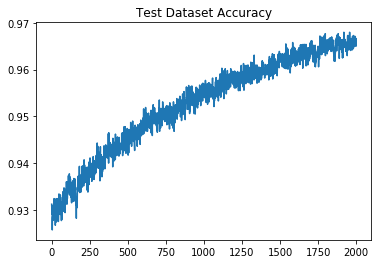

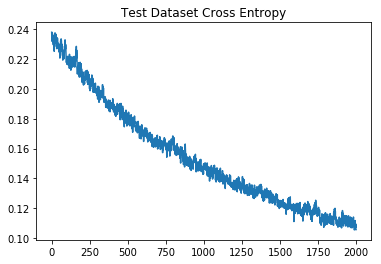

In [20]:
plt.figure()
plt.title("Test Dataset Accuracy")
plt.plot(test_accuracy)
plt.figure()
plt.title("Test Dataset Cross Entropy")
plt.plot(test_cross)
plt.show()